In [1]:
import numpy as np 
from scipy.stats import gaussian_kde as gkde
from sklearn.decomposition import FastICA
# -- local --
import env
import util as UT
import hogg as Hogg
# -- plotting -- 
from corner import corner
import matplotlib.pyplot as plt 
from ChangTools.plotting import prettyplot
from ChangTools.plotting import prettycolors
%matplotlib inline

## Toy-"experiment" to test Gaussian $\mathcal{L}_{gauss}$, ABC
We begin with the example laid out in Hogg's draft. 

Let data be drawn from a normal distribution with True mean $\mu = 7.0$ and True variance $V = 17.0$: 

In [99]:
Truth = np.array([7., 17.])
N = 5

In [100]:
np.random.seed(7)
data = Hogg.hoggdraw(Truth, N)

This data has 

In [130]:
mu_emp = np.mean(data)
var_emp = Hogg.hoggvar(data)
print 'mu_emp = ', mu_emp, 'var_emp = ', var_emp

mu_emp =  7.72236954977 var_emp =  15.7719421168


The correct likelihood for $\{ y_n\}$ can be written as
$$ ln \; p(\{y_n\}|\mu, V) = -\frac{1}{2} \sum_{n=1}^{N} \frac{(y_n - \mu)^2}{V} - \frac{N}{2} ln \,V$$

In [102]:
def ln_correct_likelihood(data, pars):
    mean, var = pars
    return np.sum(-0.5 * (data - mean) ** 2 / var) - (0.5 * len(data) * np.log(var))

In [103]:
def ln_prior(pars, prior_info): 
    mean, var = pars
    if mean < prior_info[0]: 
        return -np.Inf
    if mean > prior_info[1]: 
        return -np.Inf
    if var < prior_info[2]: 
        return -np.Inf
    if var > prior_info[3]: 
        return -np.Inf
    return 0. 

In [104]:
def ln_correct_posterior(pars, data, prior_info):
    lnp = ln_prior(pars, prior_info)
    if not np.isfinite(lnp):
        return -np.Inf
    return lnp + ln_correct_likelihood(data, pars)

In [105]:
def mcmc_step(pars, lnpvalue, lnp, args, stepsizes=None):
    newpars = pars + stepsizes * np.random.normal(size=len(pars))
    newlnpvalue = lnp(newpars, *args)
    if (newlnpvalue - lnpvalue) > np.log(np.random.uniform()):
        return newpars, newlnpvalue
    return pars.copy(), lnpvalue

def mcmc(pars0, lnp, nsteps, args, stepsizes=None):
    pars = pars0.copy()
    lnpvalue = lnp(pars, *args)
    parss = np.zeros((nsteps, len(pars)))
    for k in range(nsteps):
        pars, lnpvalue = mcmc_step(pars, lnpvalue, lnp, args, stepsizes=stepsizes)
        parss[k,:] = pars
    return parss


In [106]:
prior_info = np.array([0., 10., 0., 100.])
stepsizes = np.array([4., 4.])
pars0 = Truth.copy() 
Tbig = 2**19
thinfactor = 2 ** 4
correct_mcmc_samples = mcmc(pars0, ln_correct_posterior, Tbig, (data, prior_info, ), stepsizes=stepsizes)

In [107]:
accept = correct_mcmc_samples[1:] != correct_mcmc_samples[:-1]
print np.mean(accept)
correct_mcmc_samples = correct_mcmc_samples[::thinfactor]
print correct_mcmc_samples.shape

0.454701337245
(32768, 2)


Parameter inference with this correct likelihood with uniform priors $0 < \mu < 10$ and $0 < V < 100$ gives us: 

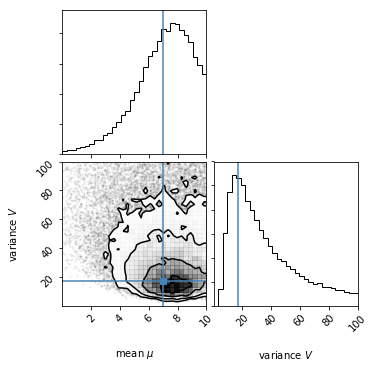

In [108]:
fig = corner(correct_mcmc_samples, bins=32, labels=[r'mean $\mu$', r'variance $V$'], 
             range=[prior_info[0:2], prior_info[2:4]], truths=Truth)

But analogous in spirit as standard cosmological analyses, if we use a pseudo Gaussian likelihood of the for
$$ ln \; p_{pseudo}(s_y^2|V) \propto -\frac{1}{2} \frac{(s_y^2 - V)^2}{\Sigma^2}$$
where $\Sigma^2$ is the empirical variance of variance. For gaussian
$$\Sigma = \frac{2 (s_y^2)^2}{N-1}$$

In [109]:
def ln_pseudo_likelihood(empiricalvar, pars, varvar):
    mean, var = pars
    return (-0.5 * (empiricalvar - var ) ** 2 / varvar)

def ln_pseudo_posterior(pars, empiricalvar, varvar, prior_info):
    lnp = ln_prior(pars, prior_info)
    if not np.isfinite(lnp):
        return -np.Inf
    return lnp + ln_pseudo_likelihood(empiricalvar, pars, varvar)

In [110]:
varvar = 2 * var_emp * var_emp / float(N - 1)
pseudo_mcmc_samples = mcmc(pars0, ln_pseudo_posterior, Tbig, (var_emp, varvar, prior_info, ), stepsizes=stepsizes)

In [111]:
accept = pseudo_mcmc_samples[1:] != pseudo_mcmc_samples[:-1]
print "acceptance ratio", np.mean(accept)
pseudo_mcmc_samples = pseudo_mcmc_samples[::thinfactor] # thin
print(pseudo_mcmc_samples.shape)

acceptance ratio 0.599223326155
(32768, 2)


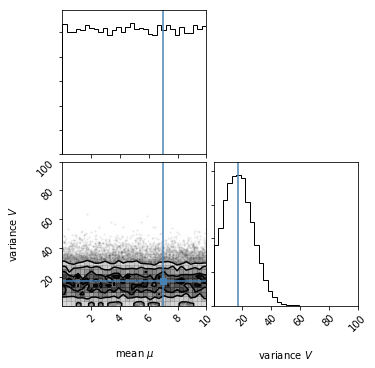

In [112]:
fig = corner(pseudo_mcmc_samples, bins=32, labels=[r'mean $\mu$', r'variance $V$'], 
             range=[prior_info[0:2], prior_info[2:4]], truths=Truth)

Here's a more direct comparison of the posteriors

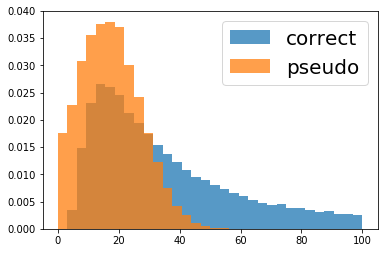

In [113]:
fig = plt.figure()
sub = fig.add_subplot(111)
n, _, _ = sub.hist(correct_mcmc_samples[:,-1], bins=32, range=[0, 100], normed=True, alpha=0.75, label="correct")
n, _, _ = sub.hist(pseudo_mcmc_samples[:,-1], bins=32, range=[0, 100], normed=True, alpha=0.75, label="pseudo")
sub.legend(loc='upper right', prop={'size': 20})

Another assumption in cosmological analyses is 
$$ ln \; p(s_y^2|V_{fid})$$
i.e. the likelihood is evaluated at some fiducial parameter. So even if you don't assume a Gaussian pseudo-likelihood
$$ p(s_y^2|V_{fid}) \neq p(s_y^2|V)$$

In an analogous fashion as cosmological analyses, lets generate some mocks

In [114]:
var_mocks = []
for seed in range(8,1008): 
    np.random.seed(seed)
    emp_truth = np.array([mu_emp, var_emp])
    mock = Hogg.hoggdraw(emp_truth, N)
    var_mocks.append(Hogg.hoggvar(mock))
var_mocks = np.array(var_mocks)

In [115]:
K = gkde(var_mocks)

Note that $p(s_y^2|V_{fid})$ is not Gaussian

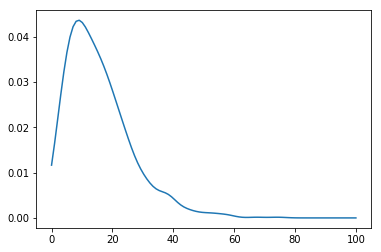

In [116]:
x = np.linspace(0., 100., 100)
plt.plot(x, K.evaluate(x))#var_mocks)

In [117]:
def ln_mock_likelihood(pars):
    mean, var = pars
    return np.log(K.evaluate(var))

def ln_mock_posterior(pars, prior_info):
    lnp = ln_prior(pars, prior_info)
    if not np.isfinite(lnp):
        return -np.Inf
    return lnp + ln_mock_likelihood(pars)

In [118]:
mock_mcmc_samples = mcmc(pars0, ln_mock_posterior, Tbig, (prior_info, ), stepsizes=stepsizes)

In [119]:
accept = mock_mcmc_samples[1:] != mock_mcmc_samples[:-1]
print "acceptance ratio", np.mean(accept)

acceptance ratio 0.585597201533


In [120]:
mock_mcmc_samples = mock_mcmc_samples[::thinfactor] # thin
print(mock_mcmc_samples.shape)

(32768, 2)


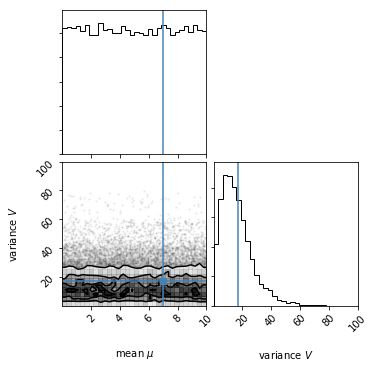

In [121]:
fig = corner(mock_mcmc_samples, bins=32, labels=[r'mean $\mu$', r'variance $V$'], 
             range=[prior_info[0:2], prior_info[2:4]], truths=Truth)

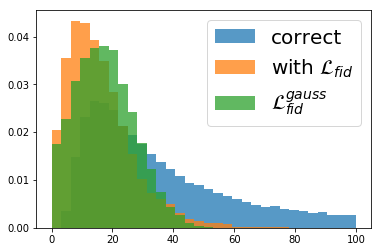

In [122]:
fig = plt.figure()
sub = fig.add_subplot(111)
n, _, _ = sub.hist(correct_mcmc_samples[:,-1], bins=32, range=[0, 100], normed=True, alpha=0.75, label="correct")
n, _, _ = sub.hist(mock_mcmc_samples[:,-1], bins=32, range=[0, 100], normed=True, alpha=0.75, label="with $\mathcal{L}_{fid}$")
n, _, _ = sub.hist(pseudo_mcmc_samples[:,-1], bins=32, range=[0, 100], normed=True, alpha=0.75, label="$\mathcal{L}^{gauss}_{fid}$")
sub.legend(loc='upper right', prop={'size': 20})

Finally now ABC recovers the true posterior!

In [123]:
def abc_mcmc(pars0, lnp, nsteps, args, stepsizes=None): 
    pars = pars0.copy() 
    lnpvalue = ln_prior(pars, args[-1])
    parss = np.zeros((nsteps, len(pars)))
    for k in range(nsteps): 
        pars, lnpvalue = mcmc_step(pars, lnpvalue, lnp, args, stepsizes=stepsizes)
        parss[k,:] = pars
    return parss

In [124]:
def ln_abc_function(pars, empiricalvar, varvar, N, threshold, prior_info):
    lnp = ln_prior(pars, prior_info)
    if not np.isfinite(lnp):
        return -np.Inf
    mean, var = pars
    thisdata = mean + np.sqrt(var) * np.random.normal(size=N)
    thispars = [mean, Hogg.hoggvar(thisdata)]
    if ln_pseudo_likelihood(empiricalvar, thispars, varvar) < -0.5 * threshold: # NEGATIVE 0.5
        return -np.Inf
    return lnp

In [125]:
#for log2thresh in [2, 0, -2, -4, ]:
thresh = 2. ** -2
abc_mcmc_samples = abc_mcmc(pars0, ln_abc_function, 2*Tbig, (var_emp, varvar, N, thresh, prior_info, ), stepsizes=stepsizes)

In [126]:
accept = abc_mcmc_samples[1:] != abc_mcmc_samples[:-1]
print("acceptance ratio", np.mean(accept))

('acceptance ratio', 0.15444579548434781)


In [127]:
abc_mcmc_samples_thin = abc_mcmc_samples[::thinfactor*2] # thin
print(abc_mcmc_samples_thin.shape)

(32768, 2)


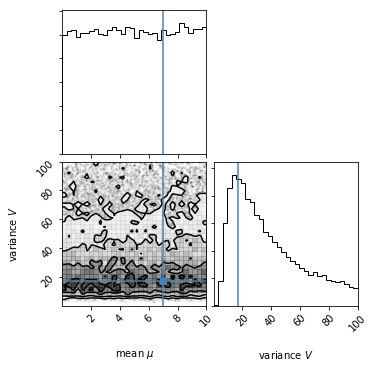

In [128]:
fig = corner(abc_mcmc_samples_thin, bins=32, labels=[r'mean $\mu$', r'variance $V$'], 
             range=[prior_info[0:2], prior_info[2:4]], truths=Truth)

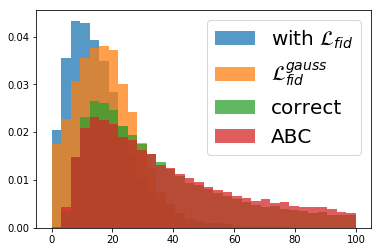

In [129]:
fig = plt.figure()
sub = fig.add_subplot(111)
n, _, _ = sub.hist(mock_mcmc_samples[:,-1], bins=32, range=[0, 100], normed=True, alpha=0.75, label="with $\mathcal{L}_{fid}$")
n, _, _ = sub.hist(pseudo_mcmc_samples[:,-1], bins=32, range=[0, 100], normed=True, alpha=0.75, label="$\mathcal{L}^{gauss}_{fid}$")
n, _, _ = sub.hist(correct_mcmc_samples[:,-1], bins=32, range=[0, 100], normed=True, alpha=0.75, label="correct")
n, _, _ = sub.hist(abc_mcmc_samples_thin[:,-1], bins=32, range=[0, 100], normed=True, alpha=0.75, label='ABC')
sub.legend(loc='upper right', prop={'size': 20})